In [232]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4, style='whitegrid')

import torch
import torchvision
from torchvision import models, datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader


from tqdm import tqdm_notebook, trange

from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import pickle
from PIL import Image

In [233]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [234]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.figure(figsize=(8, 8))
#     plt.axis('off')
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)


def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(DataLoader(val_dataset, batch_size=64, shuffle=True)):
        inp, lab = data
        inp, lab = inp.to(device), lab.to(device)

        outputs = model(inp)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inp.size()[0]):
            images_so_far += 1
            imshow(inp.cpu().data[j], class_name[preds[j]])

            if images_so_far == num_images:
                return

In [235]:
def plot_training(train_losses, valid_losses):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()

In [236]:
DATA = ['train', 'val', 'test']
RESCALE_SIZE = 224

In [237]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA:
            print(f'{self.mode} is not correct')
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, item):
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        advanced_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomRotation(degrees=45),
            transforms.RandomHorizontalFlip(p=0.7),
            transforms.RandomVerticalFlip(p=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[item])
        x = self._prepare_sample(x)

        if self.mode == 'train':
            x = advanced_transform(x)
        else:
            x = np.array(x/255, dtype='float32')
            x = base_transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[item]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [238]:
TRAIN_DIR = Path('Simpsons/train/simpsons_dataset')
TEST_DIR = Path('Simpsons/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [239]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

In [240]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i] = dct_simpsons.setdefault(label_i, []) + [path_i]

    return dct_simpsons

In [241]:
dct_path_train = create_dct_path_labels(train_files, train_labels)
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

In [242]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [243]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(new_train_files, mode='train')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [244]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=128, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=128, shuffle=True)
}

In [245]:
dataset_size = {'train': len(train_dataset), 'val': len(val_dataset)}
class_name = np.array(np.unique(train_val_labels))

In [246]:
dataset_size['train']

16895

In [247]:
def fit(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15):


    losses = {'train': [], 'val': []}
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in tqdm_notebook(range(num_epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                exp_lr_scheduler.step()
                model.train(True)
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for xb, yb, in tqdm_notebook(dataloaders[phase]):
                xb, yb = xb.to(device), yb.to(device)

                if phase == 'train':
                    optimizer.zero_grad()

                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(xb)
                else:
                    outputs = model(xb)

                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, yb)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == yb.data))

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects / dataset_size[phase]

            losses[phase].append(epoch_loss)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    model.load_state_dict(best_model_wts)
    return model, losses

In [248]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inp in test_loader:
            inp = inp.to(device)
            model.eval()
            outputs = model(inp).cpu()
            logits.append(outputs)

    probs = F.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [249]:
class SimpsonsNet(nn.Module):
    def __init__(self, num_classes=42):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8, eps=0.0001)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16, eps=0.0001)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32, eps=0.0001)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64, eps=0.0001)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(96, eps=0.0001)
        )
        self.out = nn.Sequential(
            nn.Linear(46464, 1200),
            nn.Linear(1200, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [250]:
model = SimpsonsNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [251]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
info, losses = fit(model, criterion, optimizer, exp_lr_scheduler)

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Pack\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

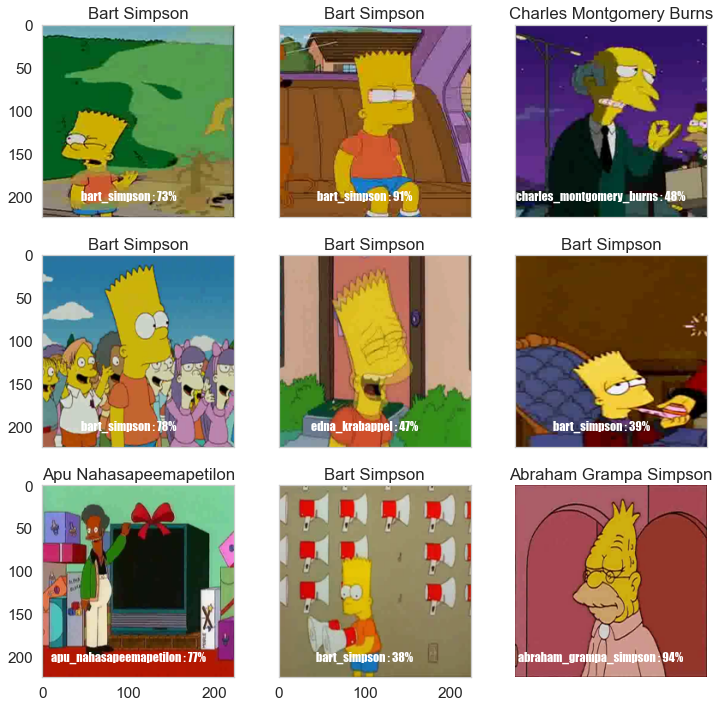

In [256]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def predict_one_sample(model, inputs):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs


label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))


import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(),
           title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    # fig_x.add_patch(patches.Rectangle((50, 195),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    # predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(100, 200, predicted_text , horizontalalignment='center', fontproperties=font,
               verticalalignment='center',fontsize=12, color='white',fontweight='bold')


In [253]:
def evaluate(model):
    model.eval()

    running_correct = 0

    for xb, yb, in DataLoader(val_dataset, batch_size=64, shuffle=True):
        xb, yb = xb.to(device), yb.to(device)

        outputs = model(xb)
        _, preds = torch.max(outputs, 1)

        running_correct += int(torch.sum(preds == yb))
    return running_correct / dataset_size['val']


print(f'Accuracy: {evaluate(model)}')

Accuracy: 0.7795185326709974


In [257]:
torch.save(model.state_dict(), 'ModelAcc77_9.pth')
model.load_state_dict(torch.load('ModelAcc77_9.pth'))

<All keys matched successfully>